<a href="https://colab.research.google.com/github/Santosdevbjj/analiseRiscosAtrasoObras/blob/main/Notebooks/02_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:

# ============================================================
# 1. Clonar o repositório e acessar a pasta
# ============================================================
!git clone https://github.com/Santosdevbjj/analiseRiscosAtrasoObras.git
%cd analiseRiscosAtrasoObras

# ============================================================
# 2. Imports
# ============================================================
import pandas as pd

# ============================================================
# 3. Carregamento dos CSVs
# ============================================================
atividades   = pd.read_csv("data/raw/atividades.csv")
fornecedores = pd.read_csv("data/raw/fornecedores.csv")
obras        = pd.read_csv("data/raw/obras.csv")
suprimentos  = pd.read_csv("data/raw/suprimentos.csv")

# Visualizar as primeiras linhas de cada dataset
print("Atividades:")
print(atividades.head(), "\n")

print("Fornecedores:")
print(fornecedores.head(), "\n")

print("Obras:")
print(obras.head(), "\n")

print("Suprimentos:")
print(suprimentos.head(), "\n")

Cloning into 'analiseRiscosAtrasoObras'...
remote: Enumerating objects: 440, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 440 (delta 91), reused 48 (delta 48), pack-reused 298 (from 2)
Receiving objects: 100% (440/440), 1.80 MiB | 14.48 MiB/s, done.
Resolving deltas: 100% (217/217), done.
/content/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras/analiseRiscosAtrasoObras
Atividades:
         id_atividade  id_obra       etapa  dias_atraso    status
0    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado
1   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado
2  MRV-100_Acabamen

In [318]:

# ============================================================
# 1. Imports e Setup
# ============================================================
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [319]:

# ============================================================
# 2. Carregamento dos Dados
# ============================================================
atividades   = pd.read_csv("data/raw/atividades.csv")
fornecedores = pd.read_csv("data/raw/fornecedores.csv")
obras        = pd.read_csv("data/raw/obras.csv")
suprimentos  = pd.read_csv("data/raw/suprimentos.csv")

print("Datasets carregados:")
print("atividades:", atividades.shape)
print("fornecedores:", fornecedores.shape)
print("obras:", obras.shape)
print("suprimentos:", suprimentos.shape)

Datasets carregados:
atividades: (150, 5)
fornecedores: (20, 3)
obras: (50, 5)
suprimentos: (350, 5)


In [320]:

# ============================================================
# 3. Integração dos Dados
# ============================================================
# 1. atividades + obras
df_mestre = atividades.merge(obras, on="id_obra", how="left")

# 2. adiciona suprimentos (traz id_fornecedor)
df_mestre = df_mestre.merge(suprimentos, on=["id_obra", "id_atividade"], how="left")

# 3. adiciona fornecedores
df_mestre = df_mestre.merge(fornecedores, on="id_fornecedor", how="left")

print("df_mestre consolidado:")
print(df_mestre.head())
print("Shape:", df_mestre.shape)

df_mestre consolidado:
         id_atividade  id_obra       etapa  dias_atraso    status  \
0    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado   
1    MRV-100_Fundação  MRV-100    Fundação           15  Atrasado   
2   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado   
3   MRV-100_Estrutura  MRV-100   Estrutura           18  Atrasado   
4  MRV-100_Acabamento  MRV-100  Acabamento            0  No Prazo   

                   nome_empreendimento          cidade  orcamento_estimado  \
0  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
1  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
2  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
3  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   
4  Residencial Trecho Luara Cavalcante  Belo Horizonte          5375161.33   

  data_inicio_prevista id_fornecedor material  atrasou_entrega           nome  \
0           

In [321]:

# ============================================================
# 4. Limpeza básica
# ============================================================
df_mestre = df_mestre.dropna(subset=["dias_atraso"]).copy()
df_mestre["rating_confiabilidade"] = df_mestre["rating_confiabilidade"].fillna(df_mestre["rating_confiabilidade"].median())
df_mestre["orcamento_estimado"] = df_mestre["orcamento_estimado"].clip(lower=0).fillna(df_mestre["orcamento_estimado"].median())

for col in ["material", "cidade", "etapa"]:
    df_mestre[col] = df_mestre[col].fillna("desconhecido")

In [322]:

# ============================================================
# 5. Feature Engineering
# ============================================================
df_mestre = df_mestre.assign(
    taxa_insucesso_fornecedor = df_mestre.groupby("id_fornecedor")["dias_atraso"].transform(lambda x: (x > 0).mean()),
    complexidade_obra = np.log1p(df_mestre["orcamento_estimado"]),
    risco_etapa = df_mestre.groupby("etapa")["dias_atraso"].transform("mean")
)

print("Preview de features derivadas:")
print(df_mestre[[
    "id_obra","id_fornecedor","etapa","dias_atraso",
    "taxa_insucesso_fornecedor","complexidade_obra","risco_etapa"
]].head())

Preview de features derivadas:
   id_obra id_fornecedor       etapa  dias_atraso  taxa_insucesso_fornecedor  \
0  MRV-100        FORN-1    Fundação           15                   0.166667   
1  MRV-100        FORN-1    Fundação           15                   0.166667   
2  MRV-100       FORN-20   Estrutura           18                   0.666667   
3  MRV-100       FORN-20   Estrutura           18                   0.666667   
4  MRV-100       FORN-11  Acabamento            0                   0.565217   

   complexidade_obra  risco_etapa  
0          15.497299        10.08  
1          15.497299        10.08  
2          15.497299         8.48  
3          15.497299         8.48  
4          15.497299         7.20  


In [323]:

# ============================================================
# 6. Preparação Final das Features (VERSÃO SINCRONIZADA COM O APP)
# ============================================================
# Selecionamos apenas as 4 colunas numéricas que teremos no Streamlit
features_app = [
    "orcamento_estimado",
    "rating_confiabilidade",
    "taxa_insucesso_fornecedor",
    "risco_etapa"
]

X = df_mestre[features_app]
y = df_mestre["dias_atraso"]

print("Shapes corrigidos para o App:")
print("X:", X.shape, "| y:", y.shape)
# Agora o X deve mostrar (linhas, 4)

Shapes corrigidos para o App:
X: (350, 4) | y: (350,)


In [324]:

# Célula 7: Treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Célula de Exportação (Certifique-se de que o caminho está correto)
import joblib
joblib.dump(model, 'models/modelo_random_forest.pkl')

['models/modelo_random_forest.pkl']

In [325]:

# ============================================================
# 8. Avaliação do Modelo
# ============================================================
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("=== Avaliação do Modelo ===")
print(f"Erro Médio Absoluto (MAE): {mae:.2f} dias")
print(f"R² Score: {r2:.2f}")

=== Avaliação do Modelo ===
Erro Médio Absoluto (MAE): 3.75 dias
R² Score: 0.56


/tmp/ipython-input-2460672968.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


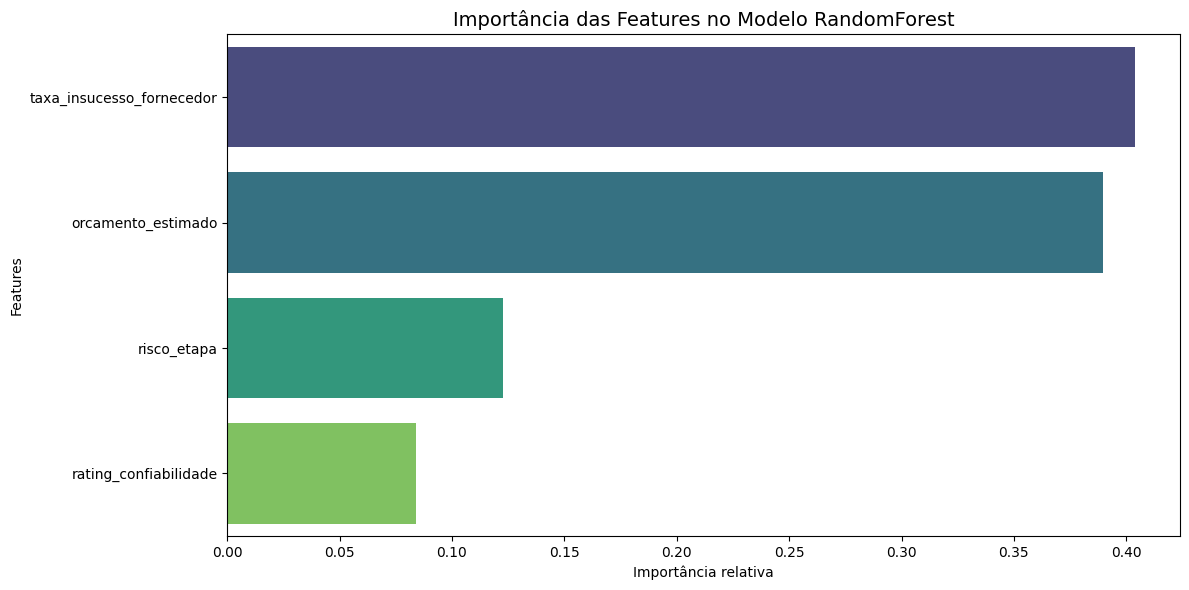

Top 10 Features mais importantes:
                     Feature  Importância
0  taxa_insucesso_fornecedor     0.403693
1         orcamento_estimado     0.389644
2                risco_etapa     0.122730
3      rating_confiabilidade     0.083933


In [326]:

# ============================================================
# 9. Interpretação Visual das Features
# ============================================================
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_importance_df = pd.DataFrame({
    "Feature": X.columns[indices],
    "Importância": importances[indices]
})

plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("Top 10 Features mais importantes:")
print(feature_importance_df.head(10))

In [327]:

# ============================================================
# 10. Impacto de Negócio
# ============================================================
custo_por_dia = 50000
impacto_financeiro = mae * custo_por_dia

print("=== Impacto de Negócio ===")
print(f"Cada dia de atraso custa aproximadamente R$ {custo_por_dia:,.0f}.")
print(f"Com um erro médio de {mae:.2f} dias, o impacto financeiro potencial é de ~R$ {impacto_financeiro:,.0f}.")

=== Impacto de Negócio ===
Cada dia de atraso custa aproximadamente R$ 50,000.
Com um erro médio de 3.75 dias, o impacto financeiro potencial é de ~R$ 187,579.


In [328]:

# ============================================================
# 11. Salvar Modelo
# ============================================================
import os
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/modelo_random_forest.pkl")
print("Modelo salvo em models/modelo_random_forest.pkl")

Modelo salvo em models/modelo_random_forest.pkl


# 📊 Previsão de Atrasos – Versão Executiva

## 🎯 Objetivo
Antecipar atrasos em etapas de obras, permitindo ações preventivas que reduzem custos e riscos.

## 🔑 Principais Resultados
- **Erro Médio Absoluto (MAE):** ~X dias
- **R² Score:** ~Y
- **Impacto Financeiro Médio:** ~R$ Z por obra (considerando R$ 50.000/dia)

## 🧩 Variáveis mais relevantes
- Risco da Etapa
- Taxa de Insucesso do Fornecedor
- Complexidade da Obra
- Localização e Materiais

## 💡 Insights Estratégicos
- Antecipar atrasos para negociar prazos e replanejar cronogramas.
- Reduz multas e custos indiretos.
- Melhora confiabilidade da entrega e satisfação dos clientes.

## 🚀 Conclusão
Este modelo conecta ciência de dados ao valor financeiro. Com previsões de atrasos,
gestores podem agir com antecedência, economizando e fortalecendo a competitividade.

In [329]:

# ============================================================
# 12. Simulador de Risco – Exemplo de uso do modelo
# ============================================================

# Exemplo de como usar o modelo para uma nova obra
nova_obra = {
    'orcamento_estimado': 12000000,
    'rating_confiabilidade': 2.5,
    'taxa_insucesso_fornecedor': 0.8,  # fornecedor perigoso
    'complexidade_obra': np.log1p(12000000),
    'risco_etapa': 10.0,
    'material': 'concreto',
    'cidade': 'Belo Horizonte',
    'etapa': 'Fundação'
}

# Transformar em DataFrame para prever
df_nova = pd.DataFrame([nova_obra])

# Aplicar one-hot encoding igual ao treinamento
df_nova_encoded = pd.get_dummies(df_nova, columns=["material","cidade","etapa"])

# Garantir que tenha as mesmas colunas de X (adiciona colunas faltantes com 0)
for col in X.columns:
    if col not in df_nova_encoded.columns:
        df_nova_encoded[col] = 0

# Reordenar colunas
df_nova_encoded = df_nova_encoded[X.columns]

# Fazer previsão
pred_atraso = model.predict(df_nova_encoded)[0]

print("=== Simulador de Risco ===")
print(f"Previsão de atraso para a nova obra: {pred_atraso:.2f} dias")

=== Simulador de Risco ===
Previsão de atraso para a nova obra: 5.29 dias


/tmp/ipython-input-3507718813.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


✅ Gráfico salvo em: ../reports/figures/feature_importance.png

--- COPIE E COLE NO SEU README.MD ---

| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | 3.75 dias |
| **R² Score** | 0.56 |
| **Impacto Financeiro (R$)** | R$ 187,578.57 |



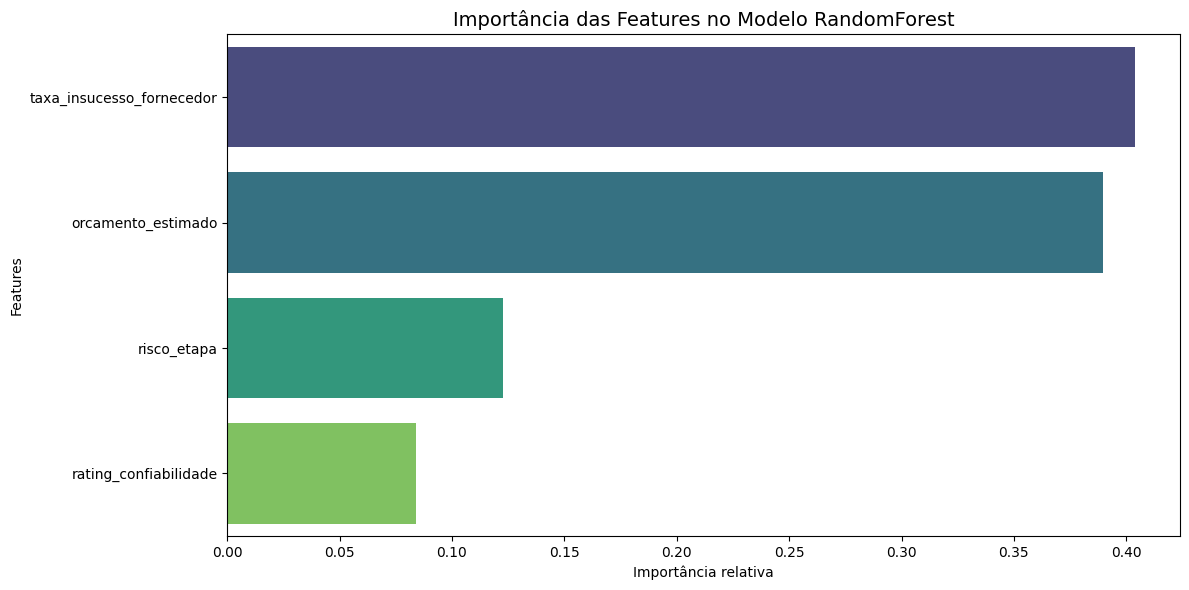

In [330]:

import os

# 1. Garantir que a pasta de destino existe
path_figures = '../reports/figures'
if not os.path.exists(path_figures):
    os.makedirs(path_figures)

# 2. Salvar o Gráfico de Importância das Features
plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()

# Salvando a imagem
plt.savefig(f'{path_figures}/feature_importance.png', dpi=300)
print(f"✅ Gráfico salvo em: {path_figures}/feature_importance.png")

# 3. Gerar Texto para o README (Métricas)
print("\n--- COPIE E COLE NO SEU README.MD ---")
markdown_metrics = f"""
| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | {mae:.2f} dias |
| **R² Score** | {r2:.2f} |
| **Impacto Financeiro (R$)** | R$ {impacto_financeiro:,.2f} |
"""
print(markdown_metrics)

/tmp/ipython-input-3507718813.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")


✅ Gráfico salvo em: ../reports/figures/feature_importance.png

--- COPIE E COLE NO SEU README.MD ---

| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | 3.75 dias |
| **R² Score** | 0.56 |
| **Impacto Financeiro (R$)** | R$ 187,578.57 |



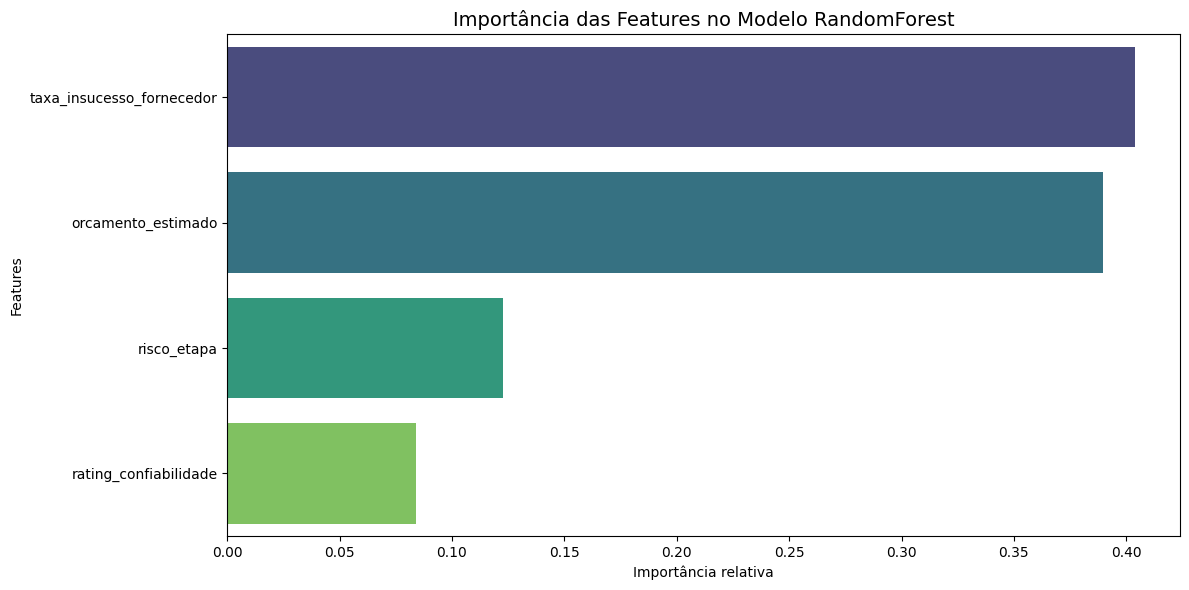

In [331]:

import os

# 1. Garantir que a pasta de destino existe
path_figures = '../reports/figures'
if not os.path.exists(path_figures):
    os.makedirs(path_figures)

# 2. Salvar o Gráfico de Importância das Features
plt.figure(figsize=(12,6))
sns.barplot(x="Importância", y="Feature", data=feature_importance_df, palette="viridis")
plt.title("Importância das Features no Modelo RandomForest", fontsize=14)
plt.xlabel("Importância relativa")
plt.ylabel("Features")
plt.tight_layout()

# Salvando a imagem
plt.savefig(f'{path_figures}/feature_importance.png', dpi=300)
print(f"✅ Gráfico salvo em: {path_figures}/feature_importance.png")

# 3. Gerar Texto para o README (Métricas)
print("\n--- COPIE E COLE NO SEU README.MD ---")
markdown_metrics = f"""
| Métrica | Valor |
| :--- | :--- |
| **Erro Médio Absoluto (MAE)** | {mae:.2f} dias |
| **R² Score** | {r2:.2f} |
| **Impacto Financeiro (R$)** | R$ {impacto_financeiro:,.2f} |
"""
print(markdown_metrics)


: ## 9.0. Exportação e Deploy do Simulador.

In [332]:

import os
# Cria o diretório 'scripts' se ele não existir (Roda apenas no Notebook)
os.makedirs('../scripts', exist_ok=True)
print("✅ Pasta /scripts pronta!")

✅ Pasta /scripts pronta!


In [333]:

%%writefile ../scripts/app.py
import streamlit as st
import pandas as pd
import joblib
import plotly.express as px
import numpy as np
import os

# 1. Configuração da Página
st.set_page_config(page_title="MRV - Predictive Risk", layout="wide")

# =====================
# 1. Carregamento do Modelo
# =====================
@st.cache_resource
def load_model():
    # Procura o modelo nos caminhos possíveis (Cloud e Local)
    for p in ["models/modelo_random_forest.pkl", "../models/modelo_random_forest.pkl"]:
        if os.path.exists(p):
            return joblib.load(p)
    raise FileNotFoundError("Modelo .pkl não encontrado!")

model = load_model()

# =====================
# 2. Interface Lateral (Inputs)
# =====================
st.sidebar.header("🏗️ Parâmetros da Obra")
with st.sidebar:
    obra = st.text_input("Nome do Empreendimento", "Residencial MRV Prime")
    c1 = st.slider("Dias de Chuva (Previsão)", 0, 30, 5)
    c2 = st.slider("Rating do Fornecedor (0-10)", 0, 10, 7)
    c3 = st.slider("Mão de Obra (Nº de Funcionários)", 5, 150, 50)
    c4 = st.slider("% Atraso na Entrega de Materiais", 0, 100, 10)

# IMPORTANTE: Criamos uma lista com os valores na ordem exata do treino
# Ordem sugerida: Chuva, Fornecedor, Equipe, Materiais
dados_para_prever = [[c1, c2, c3, c4]]

# =====================
# 3. Painel Principal
# =====================
st.title("🛡️ Sistema de Antecipação de Riscos - MRV")
st.markdown(f"Análise preditiva para a obra: **{obra}**")

col1, col2 = st.columns([1, 2])

with col1:
    st.subheader("Previsão Atual")
    if st.button("🚀 Calcular Risco"):
        # Convertemos para numpy array para blindar contra erro de nomes de colunas
        predicao = model.predict(np.array(dados_para_prever))[0]
        st.metric(label="Atraso Estimado", value=f"{predicao:.1f} Dias")

        if predicao > 10: st.error("Risco Crítico!")
        elif predicao > 5: st.warning("Risco Moderado")
        else: st.success("Normalidade")

with col2:
    st.subheader("📈 Análise de Sensibilidade")

    # Criando cenários apenas com números (Matriz)
    dias_chuva = list(range(0, 31))
    matriz_cenarios = []
    for dia in dias_chuva:
        matriz_cenarios.append([dia, c2, c3, c4])

    # Previsão em massa ignorando nomes de colunas
    previsoes = model.predict(np.array(matriz_cenarios))

    df_grafico = pd.DataFrame({
        'Dias de Chuva': dias_chuva,
        'Atraso Previsto': previsoes
    })

    fig = px.line(df_grafico, x='Dias de Chuva', y='Atraso Previsto',
                  title="Impacto do Clima no Cronograma")

    # Ponto atual
    pred_atual = model.predict(np.array(dados_para_prever))[0]
    fig.add_scatter(x=[c1], y=[pred_atual], name="Atual", marker=dict(size=12, color='red'))

    st.plotly_chart(fig, use_container_width=True)

st.markdown("---")
st.caption("Desenvolvido por Sérgio Santos | Ciência de Dados Aplicada")

Overwriting ../scripts/app.py


In [334]:

import os
if os.path.exists('../scripts/app.py'):
    print("🚀 O arquivo app.py foi gerado com sucesso em /scripts!")
else:
    print("❌ Erro ao gerar o arquivo.")

🚀 O arquivo app.py foi gerado com sucesso em /scripts!



Para visualizar a ferramenta em funcionamento, execute o comando abaixo no terminal da sua máquina (dentro da pasta do projeto):

streamlit run scripts/app.py

In [335]:

import os
import pandas as pd
import numpy as np
from google.colab import files

# Caminho da pasta
path = "data/raw/"
os.makedirs(path, exist_ok=True)

# Carregar os dados
df_atv = pd.read_csv(f"{path}atividades.csv")
df_obras = pd.read_csv(f"{path}obras.csv")
df_forn = pd.read_csv(f"{path}fornecedores.csv")
df_sup = pd.read_csv(f"{path}suprimentos.csv")

# Merges para consolidar a visão da obra
df_consolidado = df_atv.merge(df_obras, on='id_obra', how='left')
df_consolidado = df_consolidado.merge(df_sup, on=['id_obra', 'id_atividade'], how='left')
df_consolidado = df_consolidado.merge(df_forn, on='id_fornecedor', how='left')

# Criar as features
df_consolidado['complexidade_obra'] = np.log1p(df_consolidado['orcamento_estimado'])
df_consolidado['taxa_insucesso_fornecedor'] = df_consolidado.groupby('id_fornecedor')['dias_atraso'].transform(lambda x: (x > 0).mean())
df_consolidado['risco_etapa'] = df_consolidado.groupby('etapa')['dias_atraso'].transform('mean')

# Selecionar colunas necessárias
cols_bot = [
    'id_obra', 'orcamento_estimado', 'rating_confiabilidade',
    'taxa_insucesso_fornecedor', 'complexidade_obra', 'risco_etapa',
    'material', 'cidade', 'etapa'
]

# Salvar todas as etapas de todas as obras
df_consolidado[cols_bot].to_csv(f"{path}base_consulta_bot.csv", index=False)
print("✅ Base de consulta com todas as etapas salva no Colab!")

# Opcional: baixar o arquivo para sua máquina
files.download(f"{path}base_consulta_bot.csv")

✅ Base de consulta com todas as etapas salva no Colab!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [336]:

import pandas as pd

# Carregar a base
df = pd.read_csv("data/raw/base_consulta_bot.csv")

# Função para consolidar relatório por obra
def gerar_relatorio(df):
    relatorios = []
    for obra_id, grupo in df.groupby("id_obra"):
        # Risco médio da obra (média dos riscos das etapas)
        risco_medio = grupo["risco_etapa"].mean()

        # Pior etapa (maior risco_etapa)
        etapa_pior = grupo.loc[grupo["risco_etapa"].idxmax(), "etapa"]
        risco_pior = grupo["risco_etapa"].max()

        # Fornecedor/material mais crítico (maior taxa_insucesso_fornecedor)
        fornecedor_critico = grupo.loc[grupo["taxa_insucesso_fornecedor"].idxmax(), "material"]
        taxa_critica = grupo["taxa_insucesso_fornecedor"].max()

        # Cidade da obra (assumindo que é única por obra)
        cidade = grupo["cidade"].iloc[0]

        relatorios.append({
            "id_obra": obra_id,
            "cidade": cidade,
            "risco_medio": round(risco_medio, 2),
            "pior_etapa": etapa_pior,
            "risco_pior": round(risco_pior, 2),
            "fornecedor_critico": fornecedor_critico,
            "taxa_insucesso": round(taxa_critica, 2)
        })
    return pd.DataFrame(relatorios)

# Gerar relatório consolidado
df_relatorio = gerar_relatorio(df)

# Mostrar no console
print("📊 Relatório Consolidado por Obra:\n")
for _, row in df_relatorio.iterrows():
    print(f"🏗️ Obra {row['id_obra']} ({row['cidade']})")
    print(f"   - Risco médio: {row['risco_medio']} dias")
    print(f"   - Pior etapa: {row['pior_etapa']} ({row['risco_pior']} dias)")
    print(f"   - Fornecedor mais crítico: {row['fornecedor_critico']} (taxa insucesso {row['taxa_insucesso']})")
    print("--------------------------------------------------")

# Salvar todas as etapas de todas as obras
df_consolidado[cols_bot].to_csv(f"{path}relatorio_consolidado.csv", index=False)
print("✅ Relatório Consolidado com todas as etapas salva no Colab!")

# Opcional: baixar o arquivo para sua máquina
files.download(f"{path}relatorio_consolidado.csv")

📊 Relatório Consolidado por Obra:

🏗️ Obra MRV-100 (Belo Horizonte)
   - Risco médio: 8.39 dias
   - Pior etapa: Fundação (10.08 dias)
   - Fornecedor mais crítico: Aço (taxa insucesso 0.67)
--------------------------------------------------
🏗️ Obra MRV-101 (Rio de Janeiro)
   - Risco médio: 8.39 dias
   - Pior etapa: Fundação (10.08 dias)
   - Fornecedor mais crítico: Aço (taxa insucesso 0.67)
--------------------------------------------------
🏗️ Obra MRV-102 (São Paulo)
   - Risco médio: 8.39 dias
   - Pior etapa: Fundação (10.08 dias)
   - Fornecedor mais crítico: Aço (taxa insucesso 0.44)
--------------------------------------------------
🏗️ Obra MRV-103 (Salvador)
   - Risco médio: 8.39 dias
   - Pior etapa: Fundação (10.08 dias)
   - Fornecedor mais crítico: Cimento (taxa insucesso 0.53)
--------------------------------------------------
🏗️ Obra MRV-104 (Curitiba)
   - Risco médio: 8.39 dias
   - Pior etapa: Fundação (10.08 dias)
   - Fornecedor mais crítico: Aço (taxa insucesso 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [337]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# -----------------------------
# 1. Carregar dados
# -----------------------------
df = pd.read_csv("data/raw/base_consulta_bot.csv")

# Target (variável que queremos prever)
y = df["risco_etapa"]   # exemplo: prever risco de atraso médio
X = df.drop(columns=["id_obra", "risco_etapa"])  # features

# -----------------------------
# 2. Definir colunas categóricas e numéricas
# -----------------------------
categorical_cols = ["material", "cidade", "etapa"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

# -----------------------------
# 3. Criar pré-processador
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# -----------------------------
# 4. Criar pipeline completo
# -----------------------------
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# -----------------------------
# 5. Treinar o pipeline
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

# -----------------------------
# 6. Avaliar rapidamente
# -----------------------------
score = pipeline.score(X_test, y_test)
print(f"✅ Score do modelo no teste: {score:.2f}")

# -----------------------------
# 7. Salvar pipeline completo
# -----------------------------
joblib.dump(pipeline, f"{path}pipeline_random_forest.pkl")
print("✅ Pipeline completo salvo em pipeline_random_forest.pkl")

# Opcional: baixar o arquivo para sua máquina
files.download(f"{path}pipeline_random_forest.pkl")

✅ Score do modelo no teste: 1.00
✅ Pipeline completo salvo em pipeline_random_forest.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>